<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Feature-Selection" data-toc-modified-id="Feature-Selection-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Feature Selection</a></span><ul class="toc-item"><li><span><a href="#Variance-Thresholding" data-toc-modified-id="Variance-Thresholding-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Variance Thresholding</a></span></li><li><span><a href="#Anova-Test" data-toc-modified-id="Anova-Test-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Anova Test</a></span></li><li><span><a href="#RFE-(Recursive-Feature-Elimination)" data-toc-modified-id="RFE-(Recursive-Feature-Elimination)-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>RFE (Recursive Feature Elimination)</a></span></li><li><span><a href="#Feature-Selection-using-RandomForest" data-toc-modified-id="Feature-Selection-using-RandomForest-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Feature Selection using RandomForest</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></li><li><span><a href="#Modelling" data-toc-modified-id="Modelling-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Modelling</a></span><ul class="toc-item"><li><span><a href="#Anova-Features" data-toc-modified-id="Anova-Features-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Anova Features</a></span><ul class="toc-item"><li><span><a href="#RandomForest" data-toc-modified-id="RandomForest-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>RandomForest</a></span></li><li><span><a href="#Decision-tree-modelling" data-toc-modified-id="Decision-tree-modelling-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Decision tree modelling</a></span></li><li><span><a href="#LinearSVC" data-toc-modified-id="LinearSVC-2.1.3"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>LinearSVC</a></span></li></ul></li><li><span><a href="#Hyperparameter-tuning-using-Optuna" data-toc-modified-id="Hyperparameter-tuning-using-Optuna-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Hyperparameter tuning using Optuna</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Results</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></li></ul></div>

<center><h1>Feature Selection</h1></center>

In [117]:
from functools import partial

import numpy as np
import pandas as pd
import seaborn as sns

from sklearnex import patch_sklearn

patch_sklearn()

from sklearn.experimental import enable_halving_search_cv
from sklearn.utils.validation import check_is_fitted

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC

from sklearn import metrics

from sklearn.model_selection import (
    train_test_split,
    KFold,
    StratifiedKFold,
    GridSearchCV,
    HalvingGridSearchCV,
    cross_validate,
    cross_val_score,
    cross_val_predict,
)

from sklearn.feature_selection import (
    VarianceThreshold,
    f_classif,
    SelectKBest,
    SelectFromModel,
    RFE,
)

from imblearn import over_sampling, under_sampling, ensemble
from imblearn.metrics import (
    sensitivity_specificity_support,
    classification_report_imbalanced,
)

from skopt import BayesSearchCV, gp_minimize, space
from skopt.utils import use_named_args

import optuna

from joblib import dump, load

from prettytable import PrettyTable

from omegaconf import OmegaConf

sns.set(rc={"figure.figsize": (10, 8)}, font_scale=1.25)

np.random.seed(42)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
df = (
    pd.read_csv("./DryBeanDataset/Dry_Bean_Dataset.csv")
    .sample(frac=1)
    .reset_index(drop=True)
)

In [3]:
df.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,42339,741.226,260.199330,207.306394,1.255144,0.604347,42676,232.180294,0.771202,0.992103,0.968387,0.892317,0.006146,0.002403,0.796230,0.999383,SEKER
1,68247,1088.754,370.368146,237.863792,1.557060,0.766507,70172,294.779204,0.767683,0.972567,0.723492,0.795909,0.005427,0.001343,0.633471,0.986352,BARBUNYA
2,37856,708.716,248.430330,194.360324,1.278195,0.622835,38232,219.544429,0.744640,0.990165,0.947109,0.883726,0.006563,0.002469,0.780972,0.998235,SEKER
3,33143,648.385,222.526309,189.737379,1.172812,0.522480,33377,205.423899,0.769980,0.992989,0.990685,0.923144,0.006714,0.003008,0.852195,0.999465,SEKER
4,29925,647.570,237.714031,161.004849,1.476440,0.735703,30321,195.196551,0.785309,0.986940,0.896748,0.821140,0.007944,0.002228,0.674271,0.995521,DERMASON


In [4]:
X = df.drop("Class", axis=1)
y = df["Class"].astype("category").cat.codes

In [5]:
X.var(numeric_only=True)

Area               8.599026e+08
Perimeter          4.592007e+04
MajorAxisLength    7.343494e+03
MinorAxisLength    2.022309e+03
AspectRation       6.085026e-02
Eccentricity       8.464324e-03
ConvexArea         8.865456e+08
EquivDiameter      3.501932e+03
Extent             2.409471e-03
Solidity           2.171913e-05
roundness          3.542617e-03
Compactness        3.808552e-03
ShapeFactor1       1.272380e-06
ShapeFactor2       3.550668e-07
ShapeFactor3       9.800238e-03
ShapeFactor4       1.906595e-05
dtype: float64

In [6]:
scaler = MinMaxScaler(feature_range=(1, 10))
X_scaled = scaler.fit_transform(X)

In [7]:
X_scaled_df = pd.DataFrame(X_scaled, columns=df.columns[:-1].tolist())

In [8]:
X_scaled_df.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4
0,1.842333,2.333948,2.241553,3.259922,2.474618,6.008954,1.815939,2.564276,7.249960,9.692861,9.599492,7.534442,4.949932,6.338256,7.153161,9.939511
1,2.837961,4.475314,4.027241,4.074337,4.407996,8.116537,2.836085,3.944692,7.148074,7.361961,5.200767,5.031962,4.106907,3.261495,4.557913,7.686064
2,1.670054,2.133631,2.050793,2.914883,2.622229,6.249241,1.651059,2.285633,6.480978,9.461633,9.217301,7.311453,5.438912,6.528719,6.909876,9.740964
3,1.488937,1.761889,1.630924,2.791673,1.947392,4.944941,1.470931,1.974250,7.214565,9.798561,10.000000,8.334629,5.616748,8.092549,8.045553,9.953770
4,1.365271,1.756867,1.877097,2.025894,3.891733,7.716176,1.357548,1.748719,7.658365,9.076779,8.312734,5.686900,7.058892,5.828550,5.208494,9.271746


In [9]:
X_scaled_df.var()

Area               1.269917
Perimeter          1.743431
MajorAxisLength    1.929286
MinorAxisLength    1.436504
AspectRation       2.495305
Eccentricity       1.429793
ConvexArea         1.220357
EquivDiameter      1.702920
Extent             2.019396
Solidity           0.309189
roundness          1.142924
Compactness        2.566088
ShapeFactor1       1.750466
ShapeFactor2       2.991209
ShapeFactor3       2.491745
ShapeFactor4       0.570142
dtype: float64

## Variance Thresholding

If the variance is low or close to zero, then a feature is approximately constant and will not improve the performance of the model. In that case, it should be removed.

Variance will also be very low for a feature if only a handful of observations of that feature differ from a constant value.

What we can do is set a threshold and drop features with low variance 

In [10]:
vt = VarianceThreshold(threshold=1)
X_scaled_var_feats = vt.fit_transform(X_scaled)

In [11]:
X_scaled_var_feats_df = pd.DataFrame(
    X_scaled_var_feats, columns=X_scaled_df.columns[vt.get_support(indices=True)]
)

In [12]:
X_scaled_var_feats_df.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3
0,1.842333,2.333948,2.241553,3.259922,2.474618,6.008954,1.815939,2.564276,7.249960,9.599492,7.534442,4.949932,6.338256,7.153161
1,2.837961,4.475314,4.027241,4.074337,4.407996,8.116537,2.836085,3.944692,7.148074,5.200767,5.031962,4.106907,3.261495,4.557913
2,1.670054,2.133631,2.050793,2.914883,2.622229,6.249241,1.651059,2.285633,6.480978,9.217301,7.311453,5.438912,6.528719,6.909876
3,1.488937,1.761889,1.630924,2.791673,1.947392,4.944941,1.470931,1.974250,7.214565,10.000000,8.334629,5.616748,8.092549,8.045553
4,1.365271,1.756867,1.877097,2.025894,3.891733,7.716176,1.357548,1.748719,7.658365,8.312734,5.686900,7.058892,5.828550,5.208494


**Obvservation**

 - As we can see 2 low variance features are removed which are `Solidity` and `ShapeFactor4`

## Anova Test

Analysis of variance (ANOVA) is a statistical technique that is used to check if the means of two or more groups are significantly different from each other. ANOVA checks the impact of one or more factors by comparing the means of different samples. 

If we had categorical variables we would do another test called the $\chi^2$ test. Since we have all numeric features we do the ANOVA test.

In [13]:
anova_filter = SelectKBest(score_func=f_classif, k=8)
anova_filter.fit(X, y)

SelectKBest(k=8)

In [14]:
anova_df = pd.DataFrame(
    {
        "features": df.columns[anova_filter.get_support(indices=True)],
        "scores": anova_filter.scores_[anova_filter.get_support(indices=True)],
    }
)

In [15]:
anova_df

,features,scores
0,Area,29017.510462
1,Perimeter,24283.663708
2,MajorAxisLength,21622.237935
3,MinorAxisLength,22442.386382
4,ConvexArea,28961.791217
5,EquivDiameter,25444.547794
6,ShapeFactor1,12081.321137
7,ShapeFactor2,12329.884201


**Obvservation**

 - We have selected 8 best features according to the anova scores. 
 - We can select more features also, it can be a thought of as a hyperparameter to be tuned i.e trying different models with different number of features
 - I selected the number 8 as in the previous EDA notebook we saw that 8 principal components could be used to describe the whole dataset

## RFE (Recursive Feature Elimination)

Recursive Feature Elimination selects features by recursively considering smaller subsets of features by pruning the least important feature at each step. Here models are created iteartively and in each iteration it determines the best and worst performing features and this process continues until all the features are explored.Next ranking is given on eah feature based on their elimination orde. In the worst case, if a dataset contains N number of features RFE will do a greedy search for $N^2$ combinations of features.

In [16]:
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=8, verbose=3)
rfe.fit(X, y)

Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.


RFE(estimator=DecisionTreeClassifier(), n_features_to_select=8, verbose=3)

In [17]:
rfe.get_feature_names_out()

array(['Perimeter', 'MajorAxisLength', 'MinorAxisLength', 'roundness',
       'Compactness', 'ShapeFactor1', 'ShapeFactor3', 'ShapeFactor4'],
      dtype=object)

In [18]:
rfe_df = pd.DataFrame(
    {"features": X.columns.to_list(), "rank": rfe.ranking_, "selected": rfe.support_}
)

In [19]:
rfe_df

,features,rank,selected
0,Area,8,False
1,Perimeter,1,True
2,MajorAxisLength,1,True
3,MinorAxisLength,1,True
4,AspectRation,9,False
5,Eccentricity,7,False
6,ConvexArea,5,False
7,EquivDiameter,3,False
8,Extent,4,False
9,Solidity,2,False


**Obvservation**

 - We can see that the ones which are marked as `True` are the features selected.

## Feature Selection using RandomForest

Feature selection using Random forest comes under the category of Embedded methods. Embedded methods combine the qualities of filter and wrapper methods. They are implemented by algorithms that have their own built-in feature selection methods. Some of the benefits of embedded methods are :

1. They are highly accurate.
2. They generalize better.
3. They are interpretable

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [21]:
selector = SelectFromModel(
    estimator=RandomForestClassifier(n_estimators=100, verbose=1, n_jobs=-1)
)
selector.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(n_jobs=-1, verbose=1))

In [22]:
print(f"Selected features are: {selector.get_feature_names_out()}")

Selected features are: ['Perimeter' 'MajorAxisLength' 'MinorAxisLength' 'AspectRation'
 'EquivDiameter' 'Compactness' 'ShapeFactor1' 'ShapeFactor3']


## Conclusion

I now enlist all the methods used and the features selected

In [23]:
methods = [
    "Variance Thresholding (threshold = 1)",
    "ANOVA F-test",
    "Recursive Feature Elimination (estimator = DecisionTreeClassifier)",
    "Using RandomForest feature importance",
]

features = [
    X_scaled_var_feats_df.columns.to_list(),
    df.columns[anova_filter.get_support(indices=True)].to_list(),
    rfe.get_feature_names_out().tolist(),
    selector.get_feature_names_out().tolist(),
]

In [24]:
table = PrettyTable(["Methods", "Features Selected"])
for m, f in zip(methods, features):
    table.add_row([m, f])

In [25]:
table

Methods,Features Selected
Variance Thresholding (threshold = 1),"['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength', 'AspectRation', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2', 'ShapeFactor3']"
ANOVA F-test,"['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength', 'ConvexArea', 'EquivDiameter', 'ShapeFactor1', 'ShapeFactor2']"
Recursive Feature Elimination (estimator = DecisionTreeClassifier),"['Perimeter', 'MajorAxisLength', 'MinorAxisLength', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor3', 'ShapeFactor4']"
Using RandomForest feature importance,"['Perimeter', 'MajorAxisLength', 'MinorAxisLength', 'AspectRation', 'EquivDiameter', 'Compactness', 'ShapeFactor1', 'ShapeFactor3']"


# Modelling

In [96]:
class Modelling:
    def __init__(self, X_train, y_train, X_test, y_test, model, class_names):
        self._X_train, self._y_train, self._X_test, self._y_test = (
            X_train,
            y_train,
            X_test,
            y_test,
        )
        self._model = model
        self._tuned_model = None
        self.class_names = class_names
        self.scorer = metrics.make_scorer(metrics.f1_score, average="weighted")
        self.preds = None
        self.study = None
        self.scaler = StandardScaler()
        self.X_train_scaled = self.scaler.fit_transform(self._X_train)
        self.X_test_scaled = self.scaler.transform(self._X_test)
        
        print(f"Using model: {self._model.__class__.__name__}")

    def get_preds(self):
        """
        This method calculates the predictions either
        using base-line or tuned-model

        The sequence of calling `perform_cross_validation()`
        or `tune()` method before this depends on how it's
        going to calculate the predsictions


        Parameters
        ----------

        self.preds: the np.array of predictions

        If called after `perform_cross_validation()` uses baseline model
        If called after `tune()` used tuned_model

        """
        if self._tuned_model is not None:
            if self._tuned_model.__class__.__name__ == "LinearSVC":
                self.preds = self._tuned_model.predict(self.X_test_scaled)
            else:
                self.preds = self._tuned_model.predict(self._X_test)
        else:
            if self._model.__class__.__name__ == "LinearSVC":
                self.preds = self._model.predict(self.X_test_scaled)
            else:
                self.preds = self._model.predict(self._X_test)

    def perform_cross_validation(self, save=True):
        """
        Performs 10-fold cross-validation over the baseline model
        """
        print("Performing 10-fold cross validation")
        
        if self._model.__class__.__name__ == "LinearSVC":
            results = cross_validate(
                estimator=self._model,
                X=self.X_train_scaled,
                y=self._y_train,
                scoring=self.scorer,
                cv=StratifiedKFold(n_splits=10),
                verbose=2,
                n_jobs=-1,
                return_estimator=True,
            )
            self._model = results["estimator"][-1]
        else:
            results = cross_validate(
                estimator=self._model,
                X=self._X_train,
                y=self._y_train,
                scoring=self.scorer,
                cv=StratifiedKFold(n_splits=10),
                verbose=2,
                n_jobs=-1,
                return_estimator=True,
            )
            self._model = results["estimator"][-1]

        # Calling the get_preds() function after cross-val
        # This should use base-line model for metrics and confusion-matrix
        self.get_preds()
        
        if save:
            dump(
                self._model, 
                filename=f"./ML_models/BaseLine-{self._model.__class__.__name__}.joblib"
            )
            
        

    def plot_cf(self, save=True):
        """
        Plots the confusion matrix

        Depending on the state of tuned_model this function uses
        tuned_model or base-line model for plotting the confusion matrix.
        This behavior is controlled by `get_preds()` method.
        The sequence of model-fitting and calling get_preds defines whether
        the confusion matrix is made from base-line or tuned-model. Refer `get_preds()`

        Parameters
        ----------

        save: default=True
            To the save the cf as a .png file
        """

        if self._tuned_model is not None:
            cf = metrics.confusion_matrix(self._y_test, self.preds)
        else:
            cf = metrics.confusion_matrix(self._y_test, self.preds)

        ax = sns.heatmap(
            cf,
            annot=True,
            xticklabels=self.class_names,
            yticklabels=self.class_names,
            fmt="d",
            cmap="viridis_r",
        )

        title = str()

        if self._tuned_model is not None:
            title = f"Confusion Matrix for Tuned {self._model.__class__.__name__}"
            ax.set_title(title, fontsize="30")
        else:
            title = f"Confusion Matrix for Base-line {self._model.__class__.__name__}"
            ax.set_title(title, fontsize="30")

        ax.set_ylabel("Actual Class", fontsize="20")
        _ = ax.set_xlabel("Predicted Class", fontsize="20")

        if save:
            fig = ax.get_figure()
            fig.savefig(f"./ML_results/{title}.png", bbox_inches="tight")
            print(f"Figure saved at ./ML_results/{title}.png")

    def get_metrics(self):
        """
        This method prints the `classification_report_imbalanced()`

        Depending on the state of tuned_model this function uses
        tuned_model or base-line model calculating the metrics.
        This behavior is controlled by `get_preds()` method.
        The sequence of model-fitting and calling get_preds defines whether
        the metrics are calculated from base-line or tuned-model. Refer `get_preds()`
        """

        print(
            classification_report_imbalanced(
                self._y_test, self.preds, target_names=self.class_names
            )
        )

    def objective_all_models(self, trial):

        classifier_name = trial.suggest_categorical("clf_name", ["rf", "dt", "svm"])

        if classifier_name == "rf":
            params = {
                "max_depth": trial.suggest_categorical(
                    "rf_max_depth", [10, 20, 30, 40]
                ),
                "bootstrap": trial.suggest_categorical("rf_bootstrap", [True, False]),
                "max_features": trial.suggest_categorical(
                    "rf_max_features", ["auto", "sqrt"]
                ),
                "class_weight": trial.suggest_categorical(
                    "rf_class_weight", ["balanced", "balanced_subsample"]
                ),
                "n_jobs": -1,
            }
            self._model = RandomForestClassifier(**params)

            return np.mean(
                cross_val_score(
                    estimator=self._model,
                    X=self._X_train,
                    y=self._y_train,
                    scoring=self.scorer,
                    n_jobs=-1,
                )
            )

        elif classifier_name == "dt":
            params = {
                "max_depth": trial.suggest_categorical(
                    "dt_max_depth", [2, 3, 5, 10, 20]
                ),
                "min_samples_leaf": trial.suggest_categorical(
                    "dt_min_samples_leaf", [5, 10, 20, 50, 100]
                ),
                "max_features": trial.suggest_categorical(
                    "dt_max_features", ["sqrt", "auto", "log2"]
                ),
                "criterion": trial.suggest_categorical(
                    "dt_criterion", ["gini", "entropy"]
                ),
                "splitter": trial.suggest_categorical(
                    "dt_splitter", ["best", "random"]
                ),
            }
            self._model = DecisionTreeClassifier(**params)

            return np.mean(
                cross_val_score(
                    estimator=self._model,
                    X=self._X_train,
                    y=self._y_train,
                    scoring=self.scorer,
                    n_jobs=-1,
                )
            )

        elif classifier_name == "svm":
            params = {
                "C": trial.suggest_float("svm_C", 0.1, 3.0, log=True),
                "loss": trial.suggest_categorical(
                    "svm_loss", ["hinge", "squared_hinge"]
                ),
                "class_weight": "balanced",
            }
            self._model = LinearSVC()

            return np.mean(
                cross_val_score(
                    estimator=self._model,
                    X=self.X_train_scaled,
                    y=self._y_train,
                    scoring=self.scorer,
                    n_jobs=-1,
                )
            )
        
    def clean_hparams(self, study):
        d = {}
        for k, v in study.best_params.items():
            if k == "clf_name":
                continue
            idx = k.index("_") + 1
            k = k[idx:]
            d[k] = v

        return d
    
    def fit_tune(self, study, best_params):
        if study.best_params["clf_name"] == "rf":
            self._tuned_model = RandomForestClassifier(**best_params).fit(
                self._X_train, self._y_train
            )
        elif study.best_params["clf_name"] == "dt":
            self._tuned_model = DecisionTreeClassifier(**best_params).fit(
                self._X_train, self._y_train
            )
        else:
            self._tuned_model = LinearSVC(**best_params).fit(
                self.X_train_scaled, self._y_train
            )

    def tune(self, n_trials=50):
        
        study = optuna.create_study(
            direction="maximize", 
            study_name="DryBeanStudy",
            storage='sqlite:///DryBean.db',
            load_if_exists=True
        )
            
        # Optimize the study
        study.optimize(self.objective_all_models, n_trials=n_trials)

        best_params = self.clean_hparams(study=study)

        self.fit_tune(
            study=study, 
            best_params=best_params
        )

        # Calling the get_preds() function after cross-val
        # This should update Tuned model for metrics and confusion-matrix
        self.get_preds()
        
        # Saving the tuned model
        check_is_fitted(estimator=self._tuned_model)
        
        dump(
            self._model, 
            filename=f"./ML_models/Tuned-{self._tuned_model.__class__.__name__}.joblib"
        )
        
        return study

## Anova Features

Let's start with features selected using the ANOVA F-test

Our metric of choice is going to be `Weighted F1-score`. 
Here's a very good explanation for it: [link](https://stats.stackexchange.com/questions/463224/which-performance-metrics-for-highly-imbalanced-multiclass-dataset) 

In [97]:
feats = anova_filter.get_feature_names_out().tolist()

In [98]:
X[feats].head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,ConvexArea,EquivDiameter,ShapeFactor1,ShapeFactor2
0,42339,741.226,260.199330,207.306394,42676,232.180294,0.006146,0.002403
1,68247,1088.754,370.368146,237.863792,70172,294.779204,0.005427,0.001343
2,37856,708.716,248.430330,194.360324,38232,219.544429,0.006563,0.002469
3,33143,648.385,222.526309,189.737379,33377,205.423899,0.006714,0.003008
4,29925,647.570,237.714031,161.004849,30321,195.196551,0.007944,0.002228


In [99]:
X_ = X[feats]
y_ = y

X_train_, X_test_, y_train_, y_test_ = train_test_split(
    X_, y_, test_size=0.3, stratify=y_, random_state=42
)

In [100]:
classes = np.unique(df.Class.values)

### RandomForest

In [101]:
model = Modelling(
    X_train=X_train_,
    y_train=y_train_,
    X_test=X_test_,
    y_test=y_test_,
    model=RandomForestClassifier(n_jobs=-1, class_weight="balanced"),
    class_names=classes,
)

Using model: RandomForestClassifier


In [102]:
model.perform_cross_validation()

Performing 10-fold cross validation


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    1.7s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.9s finished


In [103]:
model.get_metrics()

                   pre       rec       spe        f1       geo       iba       sup

   BARBUNYA       0.90      0.87      0.99      0.88      0.93      0.85       397
     BOMBAY       1.00      1.00      1.00      1.00      1.00      1.00       157
       CALI       0.91      0.91      0.99      0.91      0.95      0.89       489
   DERMASON       0.91      0.91      0.97      0.91      0.94      0.87      1064
      HOROZ       0.94      0.93      0.99      0.94      0.96      0.92       578
      SEKER       0.93      0.93      0.99      0.93      0.96      0.91       608
       SIRA       0.84      0.86      0.96      0.85      0.91      0.82       791

avg / total       0.91      0.91      0.98      0.91      0.94      0.88      4084



Figure saved at ./ML_results/Confusion Matrix for Base-line RandomForestClassifier.png


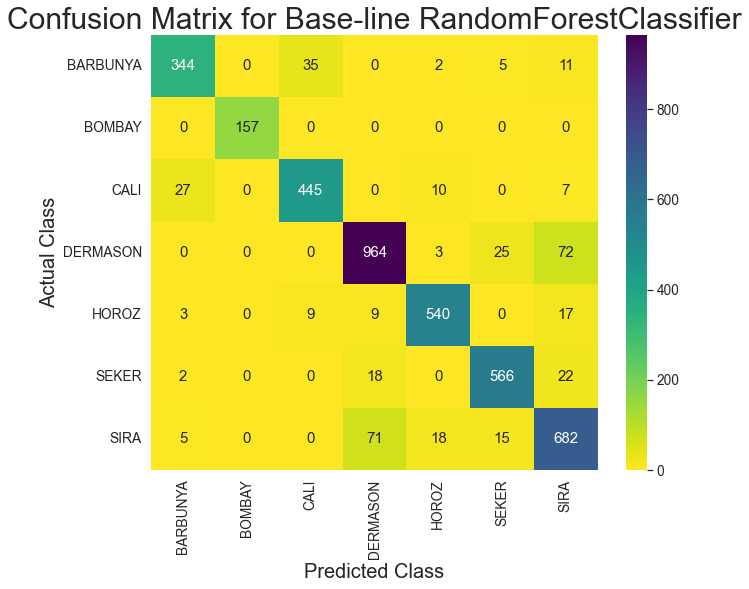

In [104]:
model.plot_cf()

### Decision tree modelling

In [108]:
dt_model = Modelling(
    X_train=X_train_,
    y_train=y_train_,
    X_test=X_test_,
    y_test=y_test_,
    model=DecisionTreeClassifier(class_weight="balanced"),
    class_names=classes,
)

Using model: DecisionTreeClassifier


In [109]:
dt_model.perform_cross_validation()

Performing 10-fold cross validation


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished


In [110]:
dt_model.get_metrics()

                   pre       rec       spe        f1       geo       iba       sup

   BARBUNYA       0.81      0.84      0.98      0.82      0.91      0.81       397
     BOMBAY       1.00      1.00      1.00      1.00      1.00      1.00       157
       CALI       0.87      0.86      0.98      0.86      0.92      0.83       489
   DERMASON       0.89      0.87      0.96      0.88      0.92      0.83      1064
      HOROZ       0.92      0.92      0.99      0.92      0.95      0.91       578
      SEKER       0.91      0.92      0.98      0.91      0.95      0.90       608
       SIRA       0.80      0.80      0.95      0.80      0.87      0.75       791

avg / total       0.87      0.87      0.97      0.87      0.92      0.84      4084



Figure saved at ./ML_results/Confusion Matrix for Base-line DecisionTreeClassifier.png


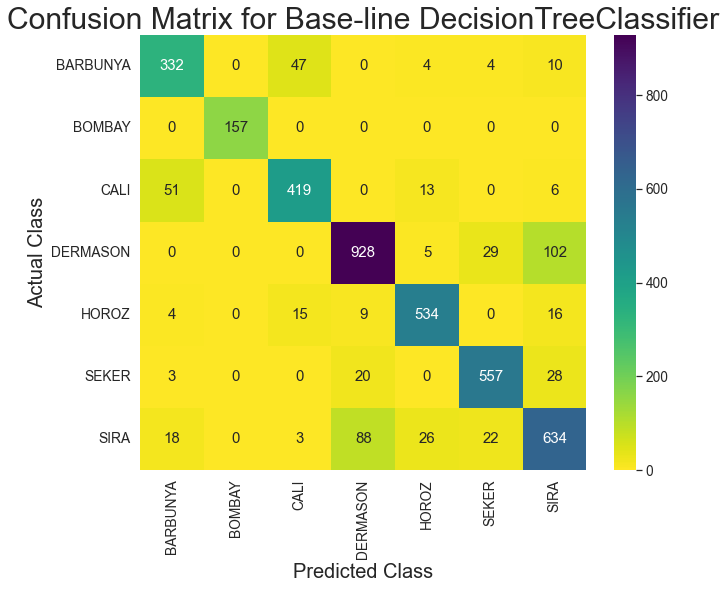

In [111]:
dt_model.plot_cf()

### LinearSVC

In [112]:
svm_model = Modelling(
    X_train=X_train_,
    y_train=y_train_,
    X_test=X_test_,
    y_test=y_test_,
    model=LinearSVC(max_iter=5000),
    class_names=classes,
)

Using model: LinearSVC


In [113]:
svm_model.perform_cross_validation()

Performing 10-fold cross validation


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.6s finished


In [114]:
svm_model.get_metrics()

                   pre       rec       spe        f1       geo       iba       sup

   BARBUNYA       0.95      0.85      1.00      0.90      0.92      0.83       397
     BOMBAY       1.00      1.00      1.00      1.00      1.00      1.00       157
       CALI       0.90      0.94      0.99      0.92      0.97      0.93       489
   DERMASON       0.92      0.89      0.97      0.90      0.93      0.86      1064
      HOROZ       0.95      0.94      0.99      0.94      0.96      0.93       578
      SEKER       0.95      0.94      0.99      0.94      0.96      0.93       608
       SIRA       0.82      0.90      0.95      0.86      0.93      0.85       791

avg / total       0.91      0.91      0.98      0.91      0.94      0.89      4084



Figure saved at ./ML_results/Confusion Matrix for Base-line LinearSVC.png


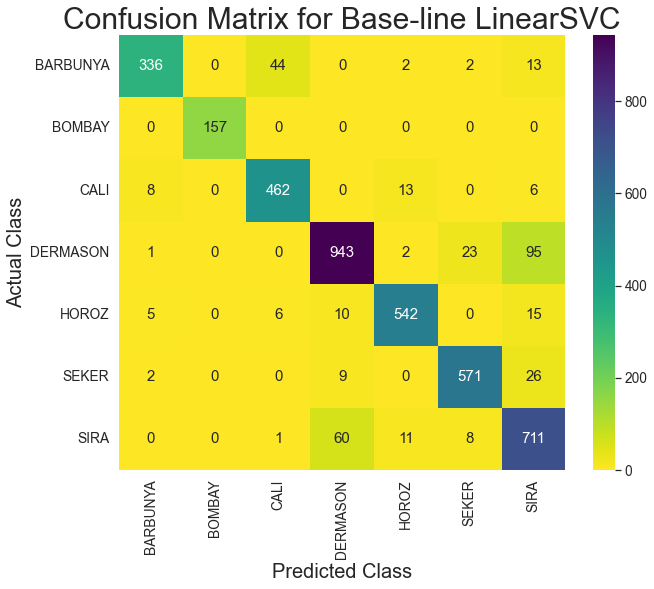

In [115]:
svm_model.plot_cf()

## Hyperparameter tuning using Optuna

In [116]:
study = svm_model.tune(n_trials=100)

[I 2022-02-06 23:12:03,306] Using an existing study with name 'DryBeanStudy' instead of creating a new one.
[I 2022-02-06 23:12:03,706] Trial 195 finished with value: 0.9089926640196608 and parameters: {'clf_name': 'svm', 'svm_C': 0.7096800634217435, 'svm_loss': 'hinge'}. Best is trial 2 with value: 0.9089926640196608.
[I 2022-02-06 23:12:04,056] Trial 196 finished with value: 0.9089926640196608 and parameters: {'clf_name': 'svm', 'svm_C': 1.9387380793607198, 'svm_loss': 'hinge'}. Best is trial 2 with value: 0.9089926640196608.
[I 2022-02-06 23:12:04,407] Trial 197 finished with value: 0.9089926640196608 and parameters: {'clf_name': 'svm', 'svm_C': 0.10460279469298202, 'svm_loss': 'hinge'}. Best is trial 2 with value: 0.9089926640196608.
[I 2022-02-06 23:12:04,750] Trial 198 finished with value: 0.9089926640196608 and parameters: {'clf_name': 'svm', 'svm_C': 1.1156282311920909, 'svm_loss': 'hinge'}. Best is trial 2 with value: 0.9089926640196608.
[I 2022-02-06 23:12:05,045] Trial 199 f

[I 2022-02-06 23:12:16,519] Trial 230 finished with value: 0.9089926640196608 and parameters: {'clf_name': 'svm', 'svm_C': 0.3982196860719412, 'svm_loss': 'squared_hinge'}. Best is trial 2 with value: 0.9089926640196608.
[I 2022-02-06 23:12:16,884] Trial 231 finished with value: 0.9089926640196608 and parameters: {'clf_name': 'svm', 'svm_C': 0.20173020033152989, 'svm_loss': 'squared_hinge'}. Best is trial 2 with value: 0.9089926640196608.
[I 2022-02-06 23:12:17,251] Trial 232 finished with value: 0.9089926640196608 and parameters: {'clf_name': 'svm', 'svm_C': 0.18711211617000634, 'svm_loss': 'squared_hinge'}. Best is trial 2 with value: 0.9089926640196608.
[I 2022-02-06 23:12:17,603] Trial 233 finished with value: 0.9089926640196608 and parameters: {'clf_name': 'svm', 'svm_C': 0.4163818970469482, 'svm_loss': 'squared_hinge'}. Best is trial 2 with value: 0.9089926640196608.
[I 2022-02-06 23:12:17,985] Trial 234 finished with value: 0.9089926640196608 and parameters: {'clf_name': 'svm', 

[I 2022-02-06 23:12:29,250] Trial 265 finished with value: 0.9089926640196608 and parameters: {'clf_name': 'svm', 'svm_C': 0.8236573542384628, 'svm_loss': 'squared_hinge'}. Best is trial 2 with value: 0.9089926640196608.
[I 2022-02-06 23:12:29,619] Trial 266 finished with value: 0.9089926640196608 and parameters: {'clf_name': 'svm', 'svm_C': 2.269232897836502, 'svm_loss': 'squared_hinge'}. Best is trial 2 with value: 0.9089926640196608.
[I 2022-02-06 23:12:29,998] Trial 267 finished with value: 0.9089926640196608 and parameters: {'clf_name': 'svm', 'svm_C': 0.9979274275201694, 'svm_loss': 'squared_hinge'}. Best is trial 2 with value: 0.9089926640196608.
[I 2022-02-06 23:12:30,359] Trial 268 finished with value: 0.9089926640196608 and parameters: {'clf_name': 'svm', 'svm_C': 2.0744254603405667, 'svm_loss': 'squared_hinge'}. Best is trial 2 with value: 0.9089926640196608.
[I 2022-02-06 23:12:30,500] Trial 269 finished with value: 0.48757808601489305 and parameters: {'clf_name': 'dt', 'dt

In [124]:
# trial_df = study.trials_dataframe()

In [125]:
# trail_df.to_csv("./ML_results/DryBeanStudy_trails.csv", index=False)

## Results

In [126]:
study.best_params

{'clf_name': 'svm', 'svm_C': 0.9453194088256368, 'svm_loss': 'hinge'}

In [127]:
study.best_value

0.9089926640196608

In [128]:
study.best_trial

FrozenTrial(number=2, values=[0.9089926640196608], datetime_start=datetime.datetime(2022, 2, 6, 4, 5, 59, 360444), datetime_complete=datetime.datetime(2022, 2, 6, 4, 5, 59, 769001), params={'clf_name': 'svm', 'svm_C': 0.9453194088256368, 'svm_loss': 'hinge'}, distributions={'clf_name': CategoricalDistribution(choices=('rf', 'dt', 'svm')), 'svm_C': LogUniformDistribution(high=3.0, low=0.1), 'svm_loss': CategoricalDistribution(choices=('hinge', 'squared_hinge'))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=3, state=TrialState.COMPLETE, value=None)

**Obvservation**

- As you can see, Linear SVM turns out to be the best among the 3
- Best f1-score: ~ 0.91
- Best params: 
    - 'C': 0.9453194088256368 
    - 'loss': 'hinge'

## Conclusion

This is all about hyper-parameter tuning by wrting your own classes and controlling each and every aspect of it. However, personally atleast I feel there's a better way of doing it, that is by using [`PyCaret`](https://pycaret.org/). PyCaret is a low-code library for end to end machine learning. We can do everything we did here from feature selction to modelling to hyper-parameter tuning and beyond, while all the time having complete control of the pipeline. PyCaret handles a lot of boiler plate stuff like the `Modelling` class we designed here. It also has deployment options. We haven't even done any ensembling/blending/stacking. We try all of those and more using PyCaret. 